### 대전 시내 택시 기사의 이동 위치 추천

차량 인코딩 및 차량별로 시퀀스 데이터 나누기

라이브러리 호출

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import requests
import numpy as np
import seaborn as sns
import holidays
from datetime import datetime
from sklearn.cluster import KMeans

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

데이터 불러오기

In [2]:
train_taxi_data = pd.read_csv('data/taxi/train_taxi_tims.csv', encoding='euc-kr')
train_grouped_means = pd.read_csv('data/taxi/train_group_means.csv', encoding='euc-kr')

display(train_taxi_data.head())
display(train_taxi_data.info())

,차량번호,승차시간,승차X좌표,승차Y좌표,요일
0,ewwvvl,2023-07-01 07:25:38,0.0,0.0,Saturday
1,ewwvvl,2023-07-01 08:18:38,0.0,0.0,Saturday
2,ewwvvl,2023-07-01 08:29:33,0.0,0.0,Saturday
3,ewwvvl,2023-07-01 09:13:15,0.0,0.0,Saturday
4,ewwvvl,2023-07-01 09:35:48,0.0,0.0,Saturday


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1089449 entries, 0 to 1089448
Data columns (total 5 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   차량번호    1089449 non-null  object 
 1   승차시간    1089449 non-null  object 
 2   승차X좌표   1089449 non-null  float64
 3   승차Y좌표   1089449 non-null  float64
 4   요일      1089449 non-null  object 
dtypes: float64(2), object(3)
memory usage: 41.6+ MB


None

열 이름을 영어로 변경

In [3]:
columns = {
    '차량번호': 'car_num',
    '승차시간': 'date_time',
    '승차X좌표': 'x',
    '승차Y좌표': 'y',
    '요일': 'weekday'
}

train_taxi_data = train_taxi_data.rename(columns=columns)
train_taxi_data.head()

,car_num,date_time,x,y,weekday
0,ewwvvl,2023-07-01 07:25:38,0.0,0.0,Saturday
1,ewwvvl,2023-07-01 08:18:38,0.0,0.0,Saturday
2,ewwvvl,2023-07-01 08:29:33,0.0,0.0,Saturday
3,ewwvvl,2023-07-01 09:13:15,0.0,0.0,Saturday
4,ewwvvl,2023-07-01 09:35:48,0.0,0.0,Saturday


좌표가 0인 데이터가 있는지 확인해보자. 그리고 이유를 확인해보자.

총 6792개 죄표 데이터가 0인 것으로 확인되었다.

In [4]:
display(len(train_taxi_data))
len(train_taxi_data[train_taxi_data['x'] == 0])

1089449

6792

이유는 아래와 같이 확인되었다.

* 시간대는 정상적이지만, 좌표 데이터가 0인 경우
* 1초 뒤에 재발생한 비정상적인 데이터의 경우

In [5]:
display(train_taxi_data[:10])
display(train_taxi_data[1840:1850])

,car_num,date_time,x,y,weekday
0,ewwvvl,2023-07-01 07:25:38,0.0,0.0,Saturday
1,ewwvvl,2023-07-01 08:18:38,0.0,0.0,Saturday
2,ewwvvl,2023-07-01 08:29:33,0.0,0.0,Saturday
3,ewwvvl,2023-07-01 09:13:15,0.0,0.0,Saturday
4,ewwvvl,2023-07-01 09:35:48,0.0,0.0,Saturday
5,ewwvvl,2023-07-01 09:47:06,0.0,0.0,Saturday
6,ewwvvl,2023-07-01 10:00:05,0.0,0.0,Saturday
7,ewwvvl,2023-07-01 10:11:19,0.0,0.0,Saturday
8,ewwvvl,2023-07-01 10:39:35,0.0,0.0,Saturday
9,ewwvvl,2023-07-01 11:02:50,0.0,0.0,Saturday


,car_num,date_time,x,y,weekday
1840,sqonam,2023-07-01 00:24:20,127.382053,36.330568,Saturday
1841,sqonam,2023-07-01 00:24:21,0.000000,0.000000,Saturday
1842,sqonam,2023-07-01 00:44:16,127.390960,36.336670,Saturday
1843,sqonam,2023-07-01 00:44:17,0.000000,0.000000,Saturday
1844,sqonam,2023-07-01 00:51:58,127.378057,36.337727,Saturday
1845,sqonam,2023-07-01 00:51:59,0.000000,0.000000,Saturday
1846,sqonam,2023-07-01 01:08:01,127.345442,36.357668,Saturday
1847,sqonam,2023-07-01 01:08:02,0.000000,0.000000,Saturday
1848,sqonam,2023-07-01 01:16:47,127.389234,36.350127,Saturday
1849,sqonam,2023-07-01 01:16:48,0.000000,0.000000,Saturday


좌표가 0인 데이터는 GPS 오류라고 판단하고 제거하였다.

다시 확인해보면 좌표가 0인 데이터의 개수가 0인 것을 확인할 수 있다.

In [6]:
train_taxi_data = train_taxi_data[(train_taxi_data['x'] != 0) & (train_taxi_data['y'] != 0)]

display(len(train_taxi_data))
len(train_taxi_data[train_taxi_data['x'] == 0])

1082657

0

그리고 date_time에 대한 순서도 정렬시켜준다.

In [7]:
train_taxi_data = train_taxi_data.sort_values(by=['car_num', 'date_time']).reset_index(drop=True)

In [8]:
train_taxi_data.head()

,car_num,date_time,x,y,weekday
0,acfgkx,2023-04-01 00:01:00,127.377074,36.351814,Saturday
1,acfgkx,2023-04-01 00:09:00,127.344477,36.357087,Saturday
2,acfgkx,2023-04-01 00:20:00,127.377528,36.351650,Saturday
3,acfgkx,2023-04-01 00:27:00,127.392290,36.375748,Saturday
4,acfgkx,2023-04-01 00:37:00,127.351769,36.358168,Saturday


시간대 그룹화 & 날씨 적용

In [9]:
# 승차시간을 datetime 타입으로 변경
train_taxi_data['date_time'] = pd.to_datetime(train_taxi_data['date_time'])

# 3시간 단위로 시간 그룹화
def group_by_three_hours(dt):
    hour = (dt.hour // 3) * 3
    return dt.replace(hour=hour, minute=0, second=0, microsecond=0)

# '승차시간'을 3시간 단위로 그룹화
train_taxi_data['time_group'] = train_taxi_data['date_time'].apply(group_by_three_hours)

In [10]:
train_taxi_data['time_group'].unique()

<DatetimeArray>
['2023-04-01 00:00:00', '2023-04-01 03:00:00', '2023-04-02 21:00:00',
 '2023-04-03 00:00:00', '2023-04-03 03:00:00', '2023-04-03 12:00:00',
 '2023-04-03 15:00:00', '2023-04-03 18:00:00', '2023-04-03 21:00:00',
 '2023-04-04 00:00:00',
 ...
 '2023-12-06 03:00:00', '2023-08-23 03:00:00', '2023-05-18 03:00:00',
 '2023-06-20 03:00:00', '2024-02-17 03:00:00', '2024-02-18 06:00:00',
 '2023-11-30 12:00:00', '2023-11-27 12:00:00', '2024-01-26 00:00:00',
 '2024-03-26 18:00:00']
Length: 2598, dtype: datetime64[ns]

In [11]:
display(train_taxi_data.head())
train_grouped_means.head()

,car_num,date_time,x,y,weekday,time_group
0,acfgkx,2023-04-01 00:01:00,127.377074,36.351814,Saturday,2023-04-01
1,acfgkx,2023-04-01 00:09:00,127.344477,36.357087,Saturday,2023-04-01
2,acfgkx,2023-04-01 00:20:00,127.377528,36.351650,Saturday,2023-04-01
3,acfgkx,2023-04-01 00:27:00,127.392290,36.375748,Saturday,2023-04-01
4,acfgkx,2023-04-01 00:37:00,127.351769,36.358168,Saturday,2023-04-01


,time_group,x,y,timestamp,weather
0,2023-03-31 21:00:00,127.379795,36.364660,1680296400,맑음
1,2023-04-01 00:00:00,127.389427,36.344145,1680307200,맑음
2,2023-04-01 03:00:00,127.389068,36.344804,1680318000,튼구름
3,2023-04-01 06:00:00,127.399530,36.348183,1680328800,구름조금
4,2023-04-01 09:00:00,127.398017,36.346179,1680339600,구름조금


In [12]:
train_grouped_means['time_group'] = pd.to_datetime(train_grouped_means['time_group'])

weather_map = dict(zip(train_grouped_means['time_group'], train_grouped_means['weather']))
train_taxi_data['weather'] = train_taxi_data['time_group'].apply(lambda x: weather_map[x])

train_taxi_data.drop('time_group', axis=1, inplace=True)
display(train_taxi_data.head())
train_taxi_data['weather'].unique()

,car_num,date_time,x,y,weekday,weather
0,acfgkx,2023-04-01 00:01:00,127.377074,36.351814,Saturday,맑음
1,acfgkx,2023-04-01 00:09:00,127.344477,36.357087,Saturday,맑음
2,acfgkx,2023-04-01 00:20:00,127.377528,36.351650,Saturday,맑음
3,acfgkx,2023-04-01 00:27:00,127.392290,36.375748,Saturday,맑음
4,acfgkx,2023-04-01 00:37:00,127.351769,36.358168,Saturday,맑음


array(['맑음', '튼구름', '온흐림', '실 비', '보통 비', '구름조금', '약간의 구름이 낀 하늘', '강한 비',
       '가벼운 눈', '박무', '눈', '매우 강한 비', '안개'], dtype=object)

날씨 카테고리가 너무 많기에 간단하게 통합

In [13]:
def simple_weather(x):
    if x in ['맑음', '구름조금', '약간의 구름이 낀 하늘', '튼구름']:
        return 'Sunny'
    elif x == '온흐림':
        return 'Cloudy'
    elif x in ['보통 비', '실 비', '강한 비']:
        return 'Rainy'
    elif x == '가벼운 눈':
        return 'Snowy'
    else:
        return 'Foggy'

train_taxi_data['weather'] = train_taxi_data['weather'].apply(lambda x: simple_weather(x))
train_taxi_data['weather'].unique()

array(['Sunny', 'Cloudy', 'Rainy', 'Snowy', 'Foggy'], dtype=object)

In [14]:
def get_period_of_day(hour):
    if 5 <= hour < 12:
        return 0
    elif 12 <= hour < 17:
        return 1
    elif 17 <= hour < 21:
        return 2
    else:
        return 3

def get_season(month):
    if month in [3, 4, 5]:
        return 0
    elif month in [6, 7, 8]:
        return 1
    elif month in [9, 10, 11]:
        return 2
    else:
        return 3

def is_holiday(date):
    if (date.weekday() >= 5) or (date in kr_holidays):
        return 1  # 주말이나 공휴일이면 1
    else:
        return 0  # 평일이면 0

# 한국의 공휴일 정보 가져오기
kr_holidays = holidays.KR()

# 변수 생성 (월, 시, 요일, 시간대, 계절, 휴일)
train_taxi_data['month'] = train_taxi_data['date_time'].dt.month
train_taxi_data['hour'] = train_taxi_data['date_time'].dt.hour
train_taxi_data['weekday'] = train_taxi_data['date_time'].dt.weekday
train_taxi_data['time_num'] = train_taxi_data['hour'].apply(get_period_of_day)
train_taxi_data['season_num'] = train_taxi_data['month'].apply(get_season)
train_taxi_data['is_holiday'] = train_taxi_data['date_time'].apply(is_holiday)

# 주기성을 반영한 시간, 월, 요일 데이터 변환
train_taxi_data.loc[:, 'hour_sin'] = np.sin(2 * np.pi * train_taxi_data['hour'] / 24)
train_taxi_data.loc[:, 'hour_cos'] = np.cos(2 * np.pi * train_taxi_data['hour'] / 24)

train_taxi_data.loc[:, 'month_sin'] = np.sin(2 * np.pi * train_taxi_data['month'] / 12)
train_taxi_data.loc[:, 'month_cos'] = np.cos(2 * np.pi * train_taxi_data['month'] / 12)

train_taxi_data.loc[:, 'weekday_sin'] = np.sin(2 * np.pi * train_taxi_data['weekday'] / 7)
train_taxi_data.loc[:, 'weekday_cos'] = np.cos(2 * np.pi * train_taxi_data['weekday'] / 7)

train_taxi_data.loc[:, 'time_sin'] = np.sin(2 * np.pi * train_taxi_data['time_num'] / 4)
train_taxi_data.loc[:, 'time_cos'] = np.cos(2 * np.pi * train_taxi_data['time_num'] / 4)

train_taxi_data.loc[:, 'season_sin'] = np.sin(2 * np.pi * train_taxi_data['season_num'] / 4)
train_taxi_data.loc[:, 'season_cos'] = np.cos(2 * np.pi * train_taxi_data['season_num'] / 4)

train_taxi_data.drop(['month', 'hour', 'weekday', 'time_num', 'season_num'], axis=1, inplace=True)
train_taxi_data.head()

,car_num,date_time,x,y,weather,is_holiday,hour_sin,hour_cos,month_sin,month_cos,weekday_sin,weekday_cos,time_sin,time_cos,season_sin,season_cos
0,acfgkx,2023-04-01 00:01:00,127.377074,36.351814,Sunny,1,0.0,1.0,0.866025,-0.5,-0.974928,-0.222521,-1.0,-1.836970e-16,0.0,1.0
1,acfgkx,2023-04-01 00:09:00,127.344477,36.357087,Sunny,1,0.0,1.0,0.866025,-0.5,-0.974928,-0.222521,-1.0,-1.836970e-16,0.0,1.0
2,acfgkx,2023-04-01 00:20:00,127.377528,36.351650,Sunny,1,0.0,1.0,0.866025,-0.5,-0.974928,-0.222521,-1.0,-1.836970e-16,0.0,1.0
3,acfgkx,2023-04-01 00:27:00,127.392290,36.375748,Sunny,1,0.0,1.0,0.866025,-0.5,-0.974928,-0.222521,-1.0,-1.836970e-16,0.0,1.0
4,acfgkx,2023-04-01 00:37:00,127.351769,36.358168,Sunny,1,0.0,1.0,0.866025,-0.5,-0.974928,-0.222521,-1.0,-1.836970e-16,0.0,1.0


In [15]:
copy_data = train_taxi_data[['date_time']].copy()

copy_data['date'] = copy_data['date_time'].dt.date
copy_data.loc[:, 'hour'] = copy_data['date_time'].dt.hour
copy_data.head()

,date_time,date,hour
0,2023-04-01 00:01:00,2023-04-01,0
1,2023-04-01 00:09:00,2023-04-01,0
2,2023-04-01 00:20:00,2023-04-01,0
3,2023-04-01 00:27:00,2023-04-01,0
4,2023-04-01 00:37:00,2023-04-01,0


In [16]:
subway = pd.read_csv('data/taxi/대전_역별시간별수송실적.csv')

# businessDay 피처 int -> date 타입으로 변환
def convert_date(date_int):
    date_str = str(date_int)
    return datetime.strptime(date_str, '%Y%m%d').date()

subway['businessDay'] = subway['businessDay'].apply(convert_date)
display(subway.head())

# 넓은 형식의 subway 데이터프레임을 melt 함수를 사용하여 긴 형식으로 변환
subway = subway.melt(id_vars=['businessDay', 'stationNo'], 
                             value_vars=[f"cnt_{str(hour).zfill(2)}" for hour in range(24)],
                             var_name='hour',
                             value_name='passenger_count')

# 시간대 문자열을 정수형으로 변환
subway['hour'] = subway['hour'].str.extract('(\d+)').astype(int)

subway

,businessDay,cnt_00,cnt_01,cnt_02,cnt_03,cnt_04,cnt_05,cnt_06,cnt_07,cnt_08,...,cnt_17,cnt_18,cnt_19,cnt_20,cnt_21,cnt_22,cnt_23,entryFlag,stationNo,sumCnt
0,2023-03-31,37,0,0,0,0,11,61,180,308,...,388,545,281,179,237,244,92,2,101,4346
1,2023-03-31,8,0,0,0,0,5,25,41,100,...,150,240,135,85,63,78,51,2,102,1611
2,2023-03-31,24,0,0,0,0,15,39,189,491,...,351,520,257,201,197,192,134,2,103,4285
3,2023-03-31,4,0,0,0,0,82,344,722,1030,...,1237,1551,811,523,379,165,62,2,104,14147
4,2023-03-31,17,0,0,0,0,18,42,172,535,...,555,879,510,308,167,123,62,2,105,6325


,businessDay,stationNo,hour,passenger_count
0,2023-03-31,101,0,37
1,2023-03-31,102,0,8
2,2023-03-31,103,0,24
3,2023-03-31,104,0,4
4,2023-03-31,105,0,17
...,...,...,...,...
193771,2024-03-31,118,23,31
193772,2024-03-31,119,23,48
193773,2024-03-31,120,23,55
193774,2024-03-31,121,23,36


In [17]:
# 각 시간대별로 최대 승객 수를 가진 행을 그룹핑해서 추출
subway = subway.loc[subway.groupby(['businessDay', 'hour'])['passenger_count'].idxmax()].reset_index(drop=True)

subway.loc[subway['passenger_count'] == 0, 'stationNo'] = 0
display(subway)

# date와 hour를 기준으로 병합
copy_data = pd.merge(copy_data, subway, left_on=['date', 'hour'], right_on=['businessDay', 'hour'], how='left')
copy_data.drop(['date', 'hour', 'businessDay'], axis=1, inplace=True)
copy_data

,businessDay,stationNo,hour,passenger_count
0,2023-03-31,122,0,61
1,2023-03-31,0,1,0
2,2023-03-31,0,2,0
3,2023-03-31,0,3,0
4,2023-03-31,0,4,0
...,...,...,...,...
8803,2024-03-31,104,19,503
8804,2024-03-31,116,20,505
8805,2024-03-31,116,21,470
8806,2024-03-31,116,22,382


,date_time,stationNo,passenger_count
0,2023-04-01 00:01:00,122,51
1,2023-04-01 00:09:00,122,51
2,2023-04-01 00:20:00,122,51
3,2023-04-01 00:27:00,122,51
4,2023-04-01 00:37:00,122,51
...,...,...,...
1082652,2024-03-24 19:24:00,104,475
1082653,2024-03-24 19:36:00,104,475
1082654,2024-03-24 19:53:00,104,475
1082655,2024-03-24 20:21:00,116,468


In [18]:
subway_stations = {
    101: (127.45843181707825, 36.31696278596884),
    102: (127.44879827352958, 36.31965331002355),
    103: (127.44283546246201, 36.32958173382147),
    104: (127.43288380711502, 36.33151967246783),
    105: (127.42582376362681, 36.32867478716448),
    106: (127.41956615308442, 36.32480383149942),
    107: (127.4125932086332, 36.32243097094993),
    108: (127.40492471879273, 36.328675322048426),
    109: (127.39340640073546, 36.3381671365824),
    110: (127.384576338995, 36.34554496809477),
    111: (127.3867558301604, 36.35151723070884),
    112: (127.38125924627752, 36.357487150798455),
    113: (127.37281460318431, 36.357594903143486),
    114: (127.3645898547285, 36.35827363363063),
    115: (127.35469142245078, 36.35476180973663),
    116: (127.34145139119151, 36.35372347247676),
    117: (127.3307353495554, 36.356700457673696),
    118: (127.3217987446626, 36.359090445025934),
    119: (127.31784721202901, 36.3668601375095),
    120: (127.31787675949373, 36.37412351916922),
    121: (127.31950545634093, 36.38407712934929),
    122: (127.31455617423161, 36.39217377004428),
    0: (0, 0)
}

copy_data['busiest_station_x'] = copy_data['stationNo'].apply(lambda x: subway_stations[x][0])
copy_data['busiest_station_y'] = copy_data['stationNo'].apply(lambda x: subway_stations[x][1])
copy_data.drop(['stationNo'], axis=1, inplace=True)
copy_data.head()

,date_time,passenger_count,busiest_station_x,busiest_station_y
0,2023-04-01 00:01:00,51,127.314556,36.392174
1,2023-04-01 00:09:00,51,127.314556,36.392174
2,2023-04-01 00:20:00,51,127.314556,36.392174
3,2023-04-01 00:27:00,51,127.314556,36.392174
4,2023-04-01 00:37:00,51,127.314556,36.392174


In [19]:
train_taxi_data['passenger_count'] = copy_data['passenger_count']
train_taxi_data['busiest_station_x'] = copy_data['busiest_station_x']
train_taxi_data['busiest_station_y'] = copy_data['busiest_station_y']
train_taxi_data

,car_num,date_time,x,y,weather,is_holiday,hour_sin,hour_cos,month_sin,month_cos,weekday_sin,weekday_cos,time_sin,time_cos,season_sin,season_cos,passenger_count,busiest_station_x,busiest_station_y
0,acfgkx,2023-04-01 00:01:00,127.377074,36.351814,Sunny,1,0.000000,1.000000,0.866025,-5.000000e-01,-0.974928,-0.222521,-1.000000e+00,-1.836970e-16,0.0,1.0,51,127.314556,36.392174
1,acfgkx,2023-04-01 00:09:00,127.344477,36.357087,Sunny,1,0.000000,1.000000,0.866025,-5.000000e-01,-0.974928,-0.222521,-1.000000e+00,-1.836970e-16,0.0,1.0,51,127.314556,36.392174
2,acfgkx,2023-04-01 00:20:00,127.377528,36.351650,Sunny,1,0.000000,1.000000,0.866025,-5.000000e-01,-0.974928,-0.222521,-1.000000e+00,-1.836970e-16,0.0,1.0,51,127.314556,36.392174
3,acfgkx,2023-04-01 00:27:00,127.392290,36.375748,Sunny,1,0.000000,1.000000,0.866025,-5.000000e-01,-0.974928,-0.222521,-1.000000e+00,-1.836970e-16,0.0,1.0,51,127.314556,36.392174
4,acfgkx,2023-04-01 00:37:00,127.351769,36.358168,Sunny,1,0.000000,1.000000,0.866025,-5.000000e-01,-0.974928,-0.222521,-1.000000e+00,-1.836970e-16,0.0,1.0,51,127.314556,36.392174
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1082652,zxwonf,2024-03-24 19:24:00,127.379442,36.353050,Cloudy,1,-0.965926,0.258819,1.000000,6.123234e-17,-0.781831,0.623490,1.224647e-16,-1.000000e+00,0.0,1.0,475,127.432884,36.331520
1082653,zxwonf,2024-03-24 19:36:00,127.389264,36.338975,Cloudy,1,-0.965926,0.258819,1.000000,6.123234e-17,-0.781831,0.623490,1.224647e-16,-1.000000e+00,0.0,1.0,475,127.432884,36.331520
1082654,zxwonf,2024-03-24 19:53:00,127.431892,36.332892,Cloudy,1,-0.965926,0.258819,1.000000,6.123234e-17,-0.781831,0.623490,1.224647e-16,-1.000000e+00,0.0,1.0,475,127.432884,36.331520
1082655,zxwonf,2024-03-24 20:21:00,127.424874,36.328305,Cloudy,1,-0.866025,0.500000,1.000000,6.123234e-17,-0.781831,0.623490,1.224647e-16,-1.000000e+00,0.0,1.0,468,127.341451,36.353723


엘보우 방법을 사용하여 WCSS(within-Cluster Sum of Squares)의 감소율이 급격히 완만해지는 지점을 찾는다.

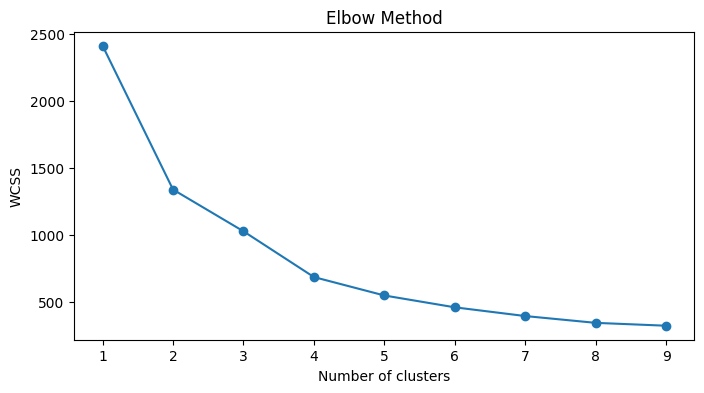

In [20]:
X = train_taxi_data[['x', 'y']].values  # x, y 좌표만 선택

# 클러스터 수를 1부터 15까지 변화시키며 WCSS 계산
wcss = []
for i in range(1, 10):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

# WCSS 값을 그래프로 표시
plt.figure(figsize=(8, 4))
plt.plot(range(1, 10), wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [21]:
# KMeans 클러스터링 모델 초기화 (4개의 클러스터)
kmeans = KMeans(n_clusters=4, random_state=42)

train_taxi_data['cluster'] = kmeans.fit_predict(train_taxi_data[['x', 'y']])

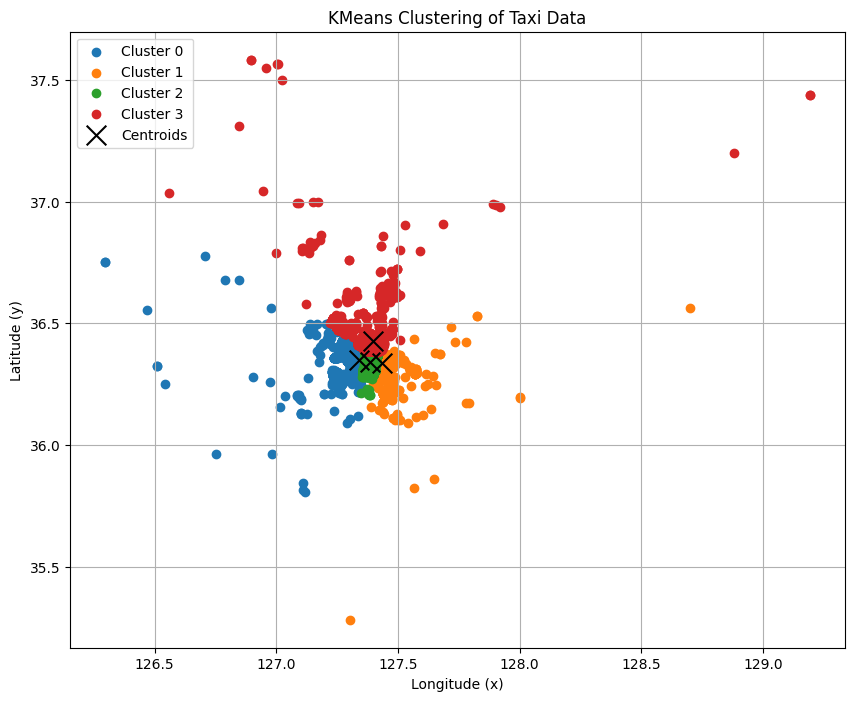

In [22]:
# 클러스터 시각화
plt.figure(figsize=(10, 8))

# 각 클러스터를 다른 색으로 표시
for cluster in range(4):
    clustered_data = train_taxi_data[train_taxi_data['cluster'] == cluster]
    plt.scatter(clustered_data['x'], clustered_data['y'], label=f'Cluster {cluster}')

# 클러스터 센터(중심) 표시
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', marker='x', s=200, label='Centroids')

# 그래프 설정
plt.xlabel('Longitude (x)')
plt.ylabel('Latitude (y)')
plt.title('KMeans Clustering of Taxi Data')
plt.legend()
plt.grid(True)
plt.show()

In [23]:
# import folium
# from folium.plugins import MarkerCluster

# # 지도 생성 (중심을 데이터의 평균 좌표로 설정)
# map_center = [train_taxi_data['y'].mean(), train_taxi_data['x'].mean()]
# map_clusters = folium.Map(location=map_center, zoom_start=12)

# # 클러스터 색상 설정
# colors = ['red', 'blue', 'green', 'purple', 'yellow']

# # 데이터 포인트를 클러스터별로 지도에 추가
# for cluster in range(5):
#     clustered_data = train_taxi_data[train_taxi_data['cluster'] == cluster]
#     for _, row in clustered_data.iterrows():
#         folium.CircleMarker(
#             location=[row['y'], row['x']],
#             radius=3,
#             color=colors[cluster],
#             fill=True,
#             fill_color=colors[cluster],
#             fill_opacity=0.6
#         ).add_to(map_clusters)

# # 지도 저장
# map_clusters.save('data/taxi/taxi_clusters_map.html')


명목형 변수(요일, 날씨, 계절)에 원-핫 인코딩을 적용해보자.

In [24]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
encoded_data = ohe.fit_transform(train_taxi_data[['weather']])
encoded_df = pd.DataFrame(encoded_data, columns=ohe.get_feature_names_out())

# 데이터프레임 연결 시 인덱스 문제로 인해 초기화
# train_taxi_data.reset_index(drop=True, inplace=True)
# encoded_df.reset_index(drop=True, inplace=True)

train_taxi_data = pd.concat([train_taxi_data, encoded_df], axis=1)
train_taxi_data.drop(['car_num', 'weather'], axis=1, inplace=True)
train_taxi_data.head()

,date_time,x,y,is_holiday,hour_sin,hour_cos,month_sin,month_cos,weekday_sin,weekday_cos,...,season_sin,season_cos,passenger_count,busiest_station_x,busiest_station_y,cluster,weather_Foggy,weather_Rainy,weather_Snowy,weather_Sunny
0,2023-04-01 00:01:00,127.377074,36.351814,1,0.0,1.0,0.866025,-0.5,-0.974928,-0.222521,...,0.0,1.0,51,127.314556,36.392174,2,0.0,0.0,0.0,1.0
1,2023-04-01 00:09:00,127.344477,36.357087,1,0.0,1.0,0.866025,-0.5,-0.974928,-0.222521,...,0.0,1.0,51,127.314556,36.392174,0,0.0,0.0,0.0,1.0
2,2023-04-01 00:20:00,127.377528,36.351650,1,0.0,1.0,0.866025,-0.5,-0.974928,-0.222521,...,0.0,1.0,51,127.314556,36.392174,2,0.0,0.0,0.0,1.0
3,2023-04-01 00:27:00,127.392290,36.375748,1,0.0,1.0,0.866025,-0.5,-0.974928,-0.222521,...,0.0,1.0,51,127.314556,36.392174,2,0.0,0.0,0.0,1.0
4,2023-04-01 00:37:00,127.351769,36.358168,1,0.0,1.0,0.866025,-0.5,-0.974928,-0.222521,...,0.0,1.0,51,127.314556,36.392174,0,0.0,0.0,0.0,1.0


In [25]:
# 정규화할 피처들
features_to_scale = ['busiest_station_x', 'busiest_station_y', 'passenger_count']

# 정규화 스케일러 생성
scaler_xy = MinMaxScaler()
scaler_other = MinMaxScaler()

# 정규화 적용
train_taxi_data[['x', 'y']] = scaler_xy.fit_transform(train_taxi_data[['x', 'y']])
train_taxi_data[features_to_scale] = scaler_other.fit_transform(train_taxi_data[features_to_scale])

In [26]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input

# 시퀀스 데이터 생성 함수
def create_sequences(df, time_steps=7):
    X, y = [], []
    
    # 클러스터를 기준으로 그룹핑
    for cluster, group in df.groupby('cluster'):
        # 시간 순서대로 정렬
        group = group.sort_values(by='date_time')

        # 피처와 타겟 분리
        features = group.drop(columns=['x', 'y', 'date_time'])  # 예측할 'x', 'y' 좌표는 제외
        targets = group[['x', 'y']]  # 예측할 좌표 타겟

        # 시퀀스 생성
        for i in range(len(group) - time_steps):
            X.append(features.iloc[i:i+time_steps].values)
            y.append(targets.iloc[i+time_steps].values)
    
    return np.array(X), np.array(y)

# 시퀀스 데이터 생성
X, y = create_sequences(train_taxi_data)

# 학습 데이터와 검증 데이터로 분리
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)

모델을 생성하기 전에 test 데이터셋에도 똑같이 적용을 해주자

In [27]:
test_taxi_data = pd.read_csv('data/taxi/test_taxi_tims.csv', encoding='euc-kr')
test_grouped_means = pd.read_csv('data/taxi/test_group_means.csv', encoding='euc-kr')

In [28]:
def feature_preprocessing(df, df_group_means, subway, df_type='train'):

    if df_type == 'train' or df_type == 'test':
        # 열 이름 변경
        df = df.rename(columns=columns)
        
        # 좌표가 0인 데이터 제거
        df = df[(df['x'] != 0) & (df['y'] != 0)]
    
        # car_num과 date_time에 대한 순서 정렬
        df = df.sort_values(by=['car_num', 'date_time']).reset_index(drop=True)
    
        # 승차시간을 datetime 타입으로 변경
        df['date_time'] = pd.to_datetime(df['date_time'])
    
        # '승차시간'을 3시간 단위로 그룹화
        df['time_group'] = df['date_time'].apply(group_by_three_hours)
    
        # 날씨 적용
        df_group_means['time_group'] = pd.to_datetime(df_group_means['time_group'])
        weather_map = dict(zip(df_group_means['time_group'], df_group_means['weather']))
        df['weather'] = df['time_group'].apply(lambda x: weather_map[x])

        df.drop(['time_group'], axis=1, inplace=True)
        
    # 날씨 간단
    df['weather'] = df['weather'].apply(lambda x: simple_weather(x))

    # 변수 생성 (월, 시, 요일, 시간대, 계절, 휴일)
    df['month'] = df['date_time'].dt.month
    df['hour'] = df['date_time'].dt.hour
    df['weekday'] = df['date_time'].dt.weekday
    df['time_num'] = df['hour'].apply(get_period_of_day)
    df['season_num'] = df['month'].apply(get_season)
    df['is_holiday'] = df['date_time'].apply(is_holiday)

    # 주기성을 반영한 시간, 월, 요일 데이터 변환
    df.loc[:, 'hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df.loc[:, 'hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    
    df.loc[:, 'month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df.loc[:, 'month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    
    df.loc[:, 'weekday_sin'] = np.sin(2 * np.pi * df['weekday'] / 7)
    df.loc[:, 'weekday_cos'] = np.cos(2 * np.pi * df['weekday'] / 7)
    
    df.loc[:, 'time_sin'] = np.sin(2 * np.pi * df['time_num'] / 4)
    df.loc[:, 'time_cos'] = np.cos(2 * np.pi * df['time_num'] / 4)
    
    df.loc[:, 'season_sin'] = np.sin(2 * np.pi * df['season_num'] / 4)
    df.loc[:, 'season_cos'] = np.cos(2 * np.pi * df['season_num'] / 4)

    df.drop(['month', 'hour', 'weekday', 'time_num', 'season_num'], axis=1, inplace=True)

    # df1(date 피처, hour 피처)
    copy_data = df[['date_time']].copy()
    copy_data['date'] = copy_data['date_time'].dt.date
    copy_data.loc[:, 'hour'] = copy_data['date_time'].dt.hour

    if df_type == 'train':
        # 정수형 타입인 날짜를 date 타입으로 변경
        subway['businessDay'] = subway['businessDay'].apply(convert_date)
    
        # 넓은 형식의 subway 데이터프레임을 melt 함수를 사용하여 긴 형식으로 변환
        subway = subway.melt(id_vars=['businessDay', 'stationNo'], 
                                 value_vars=[f"cnt_{str(hour).zfill(2)}" for hour in range(24)],
                                 var_name='hour',
                                 value_name='passenger_count')
        
        # 시간대 문자열을 정수형으로 변환
        subway['hour'] = subway['hour'].str.extract('(\d+)').astype(int)
    
        # 각 시간대별로 최대 승객 수를 가진 행을 그룹핑해서 추출
        subway = subway.loc[subway.groupby(['businessDay', 'hour'])['passenger_count'].idxmax()].reset_index(drop=True)
        subway.loc[subway['passenger_count'] == 0, 'stationNo'] = 0 # 승객이 0인 지하철 역의 역번호를 0으로 설정

    # copy data와 subway df를 병합
    copy_data = pd.merge(copy_data, subway, left_on=['date', 'hour'], right_on=['businessDay', 'hour'], how='left')
    copy_data.drop(['date', 'hour', 'businessDay'], axis=1, inplace=True)

    # 역 번호에 해당하는 x, y 좌표 피처 생
    copy_data['busiest_station_x'] = copy_data['stationNo'].apply(lambda x: subway_stations[x][0])
    copy_data['busiest_station_y'] = copy_data['stationNo'].apply(lambda x: subway_stations[x][1])
    copy_data.drop(['stationNo'], axis=1, inplace=True)

    # df에 복사
    df['passenger_count'] = copy_data['passenger_count']
    df['busiest_station_x'] = copy_data['busiest_station_x']
    df['busiest_station_y'] = copy_data['busiest_station_y']

    # 군집화 피처 생성
    df['cluster'] = kmeans.fit_predict(df[['x', 'y']])

    # 날씨 피처 원핫 인코딩
    if df_type == 'train':
        encoded_data = ohe.fit_transform(df[['weather']])
    elif df_type == 'test':
        encoded_data = ohe.transform(df[['weather']])
    encoded_df = pd.DataFrame(encoded_data, columns=ohe.get_feature_names_out())
    df = pd.concat([df, encoded_df], axis=1)
    df.drop(['car_num', 'weather'], axis=1, inplace=True)

    # 정규화 적용
    if df_type == 'train':
        df[['x', 'y']] = scaler_xy.fit_transform(df[['x', 'y']])
        df[features_to_scale] = scaler_other.fit_transform(df[features_to_scale])
    elif df_type == 'test':
        df[['x', 'y']] = scaler_xy.transform(df[['x', 'y']])
        df[features_to_scale] = scaler_other.transform(df[features_to_scale])

    return df
    
test_taxi_data = feature_preprocessing(test_taxi_data, test_grouped_means, subway, "test")
test_taxi_data.head()

,date_time,x,y,is_holiday,hour_sin,hour_cos,month_sin,month_cos,weekday_sin,weekday_cos,...,season_sin,season_cos,passenger_count,busiest_station_x,busiest_station_y,cluster,weather_Foggy,weather_Rainy,weather_Snowy,weather_Sunny
0,2023-05-25 05:31:00,0.397435,0.448676,0,0.965926,2.588190e-01,0.5,-0.866025,0.433884,-0.900969,...,0.0,1.0,0.030566,0.9998,0.998333,1,0.0,0.0,0.0,1.0
1,2023-05-25 05:57:00,0.395080,0.464368,0,0.965926,2.588190e-01,0.5,-0.866025,0.433884,-0.900969,...,0.0,1.0,0.030566,0.9998,0.998333,1,0.0,0.0,0.0,1.0
2,2023-05-25 06:06:00,0.391363,0.464707,0,1.000000,6.123234e-17,0.5,-0.866025,0.433884,-0.900969,...,0.0,1.0,0.092781,0.9998,0.998333,1,0.0,0.0,0.0,0.0
3,2023-05-25 06:22:00,0.387498,0.475898,0,1.000000,6.123234e-17,0.5,-0.866025,0.433884,-0.900969,...,0.0,1.0,0.092781,0.9998,0.998333,1,0.0,0.0,0.0,0.0
4,2023-05-25 06:32:00,0.391304,0.472662,0,1.000000,6.123234e-17,0.5,-0.866025,0.433884,-0.900969,...,0.0,1.0,0.092781,0.9998,0.998333,1,0.0,0.0,0.0,0.0


In [29]:
# 시퀀스 데이터 생성
X_test, y_test = create_sequences(test_taxi_data)

In [30]:
# LSTM 모델 구성
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X.shape[1], X.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(2))  # X, Y 좌표 두 개의 값을 예측

# 모델 컴파일
model.compile(optimizer='adam', loss='mse')

# 모델 학습
model.fit(X, y, epochs=5, batch_size=32, validation_data=(X_test, y_test), verbose=1)

C:\Users\CHOYS\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
33833/33833 ━━━━━━━━━━━━━━━━━━━━ 111s 3ms/step - loss: 9.9249e-04 - val_loss: 9.3227e-05
Epoch 2/5
33833/33833 ━━━━━━━━━━━━━━━━━━━━ 104s 3ms/step - loss: 5.5470e-05 - val_loss: 8.5662e-05
Epoch 3/5
33833/33833 ━━━━━━━━━━━━━━━━━━━━ 103s 3ms/step - loss: 5.4428e-05 - val_loss: 8.5007e-05
Epoch 4/5
33833/33833 ━━━━━━━━━━━━━━━━━━━━ 102s 3ms/step - loss: 5.5433e-05 - val_loss: 8.5676e-05
Epoch 5/5
33833/33833 ━━━━━━━━━━━━━━━━━━━━ 97s 3ms/step - loss: 5.5004e-05 - val_loss: 8.5892e-05


In [31]:
ex_data = pd.DataFrame({
    'car_num': ['abcdef'],
    'date_time': [datetime.now().strftime('%Y-%m-%d %H:%M:%S')],
    'weekday': ['Wednesday']
})

ex_data

,car_num,date_time,weekday
0,abcdef,2024-10-02 02:13:39,Wednesday


1. 단일 데이터일 때 시퀀스 데이터로 어떻게 만들 것인지?
2. predict할 때는 지하철역 데이터가 X -> 과거 시간대, 요일, 날씨가 같을 때 과거 지하철 데이터의 평균을 이용
3. 하나의 데이터를 이용하여 10개의 좌표를 어떻게 예측할 것인지? -> 가중치 부여하라고 하긴 하는데 자세히는 모름

In [33]:
# 예측
# y_pred = model.predict(X_test)

In [34]:
# # 예측값과 실제값을 역정규화 (실제 위도/경도 좌표로 복원)
# y_test_original = scaler_xy.inverse_transform(y_test)
# y_pred_original = scaler_xy.inverse_transform(y_pred)

# # Haversine 공식을 사용하여 두 좌표 사이의 거리를 계산하는 함수
# def haversine_distance(lat1, lon1, lat2, lon2):
#     R = 6371  # 지구 반지름 (단위: km)
#     dlat = np.radians(lat2 - lat1)
#     dlon = np.radians(lon2 - lon1)
#     a = np.sin(dlat / 2) ** 2 + np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) * np.sin(dlon / 2) ** 2
#     c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
#     distance = R * c
#     return distance

# # Haversine 공식을 사용하여 실제 거리 오차 계산
# distances = haversine_distance(
#     y_test_original[:, 1], y_test_original[:, 0],  # 실제 경도, 위도
#     y_pred_original[:, 1], y_pred_original[:, 0]   # 예측 경도, 위도
# )

# # 평균 거리 오차 출력
# mean_distance_error_seq = np.mean(distances)
# print(f"평균 거리 오차: {mean_distance_error_seq:.2f} km")

## 날씨 데이터 얻는 과정

Openweather API를 이용해서 날씨를 적용할 것이다. 하루에 1000번 호출하는 것까지 무료이고 그 이후부터는 유료이기 때문에 행 하나하나에 모두 적용하는 것은 불가능하다. 따라서 시간대를 나누고 시간대별 좌표의 평균을 구한다음에 그 좌표를 API에 적용하면 꽤나 단축 가능하다.

### train 데이터셋 적용

In [35]:
# train_grouped_means = train_taxi_data.groupby('time_group')[['x', 'y']].mean().reset_index()
train_grouped_means.head()

,time_group,x,y,timestamp,weather
0,2023-03-31 21:00:00,127.379795,36.364660,1680296400,맑음
1,2023-04-01 00:00:00,127.389427,36.344145,1680307200,맑음
2,2023-04-01 03:00:00,127.389068,36.344804,1680318000,튼구름
3,2023-04-01 06:00:00,127.399530,36.348183,1680328800,구름조금
4,2023-04-01 09:00:00,127.398017,36.346179,1680339600,구름조금


In [36]:
# def convert_timestamp(date_time):
#     timestamp = int(date_time.timestamp())
#     return timestamp

# train_grouped_means['timestamp'] = train_grouped_means['time_group'].apply(convert_timestamp)
# train_grouped_means['weather'] = None
# train_grouped_means.head()

In [37]:
# API_key = '26b2690c05559a7396f701113f306e9f'
# lang = 'kr'

# for index, row in train_grouped_means.iterrows():
#     lon = row['x']
#     lat = row['y']
#     timestamp = row['timestamp']

#     url = f'https://api.openweathermap.org/data/3.0/onecall/timemachine?lat={lat}&lon={lon}&dt={timestamp}&appid={API_key}&lang={lang}'
#     response = requests.get(url)

#     if response.status_code == 200:
#         weather_description = response.json()['data'][0]['weather'][0]['description']
#         train_grouped_means.loc[index, 'weather'] = weather_description
#     else:
#         train_grouped_means.loc[index, 'weather'] = None

In [38]:
# train_grouped_means.to_csv('data/taxi/train_group_means.csv', index=False, encoding='euc-kr')

### test 데이터셋 적용

In [39]:
# test_grouped_means = test_taxi_data.groupby('time_group')[['x', 'y']].mean().reset_index()

In [40]:
# test_grouped_means['timestamp'] = test_grouped_means['time_group'].apply(convert_timestamp)
# test_grouped_means['weather'] = None
# test_grouped_means.head()

In [41]:
# API_key = '26b2690c05559a7396f701113f306e9f'
# lang = 'kr'

# for index, row in test_grouped_means.iterrows():
#     lon = row['x']
#     lat = row['y']
#     timestamp = row['timestamp']

#     url = f'https://api.openweathermap.org/data/3.0/onecall/timemachine?lat={lat}&lon={lon}&dt={timestamp}&appid={API_key}&lang={lang}'
#     response = requests.get(url)

#     if response.status_code == 200:
#         weather_description = response.json()['data'][0]['weather'][0]['description']
#         test_grouped_means.loc[index, 'weather'] = weather_description
#     else:
#         test_grouped_means.loc[index, 'weather'] = None

In [42]:
# test_grouped_means.to_csv('data/taxi/test_group_means.csv', index=False, encoding='euc-kr')

### 대전_역별시간별승하차인원 xml 호출

In [43]:
# import requests
# from urllib.parse import unquote
# from pprint import pprint
# serviceKey = unquote('2RY9nFq9Vh9xg0Gp%2FK%2BIrptifBFzTh7rumM%2BPNtSyJ7mqwVI7sAecDK3y9QW25Zsl4RGqNHPv5he5taat2PlTg%3D%3D')
# url = 'http://www.djtc.kr/OpenAPI/service/StationPassengerSVC/getStationPassenger'
# params ={'serviceKey' : serviceKey, 'startDate' : '20240301', 'endDate' : '20240331' }

# response = requests.get(url, params=params)
# print(response.content)